In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
import warnings
import umap
warnings.filterwarnings('ignore')

c:\Users\Mateo Vasquez\Desktop\Proyectos\Censo2024\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_clusters = pd.read_parquet('output/dataset_con_clusters.parquet')

# Dataset ORIGINAL seleccionado (sin escalar) para interpretación
df_original = pd.read_parquet('output/dataset_seleccionado_para_clustering.parquet')

# Extraer labels del cluster final
cluster_labels = df_clusters['cluster_final'].values
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

print(f"\nClusters identificados: {n_clusters}")
print(f"   Outliers: {(cluster_labels == -1).sum():,} ({(cluster_labels == -1).sum()/len(cluster_labels)*100:.2f}%)")

# Agregar cluster labels al dataset original
df_original['cluster'] = cluster_labels



Clusters identificados: 5
   Outliers: 0 (0.00%)



DISTRIBUCIÓN DE CLUSTERS

Tamaño de cada cluster:

   Cluster 0:  48,641 hogares (84.79%)
   Cluster 1:   1,287 hogares ( 2.24%)
   Cluster 2:   3,013 hogares ( 5.25%)
   Cluster 3:   2,575 hogares ( 4.49%)
   Cluster 4:   1,850 hogares ( 3.22%)

Gráfico guardado: distribucion_clusters.png


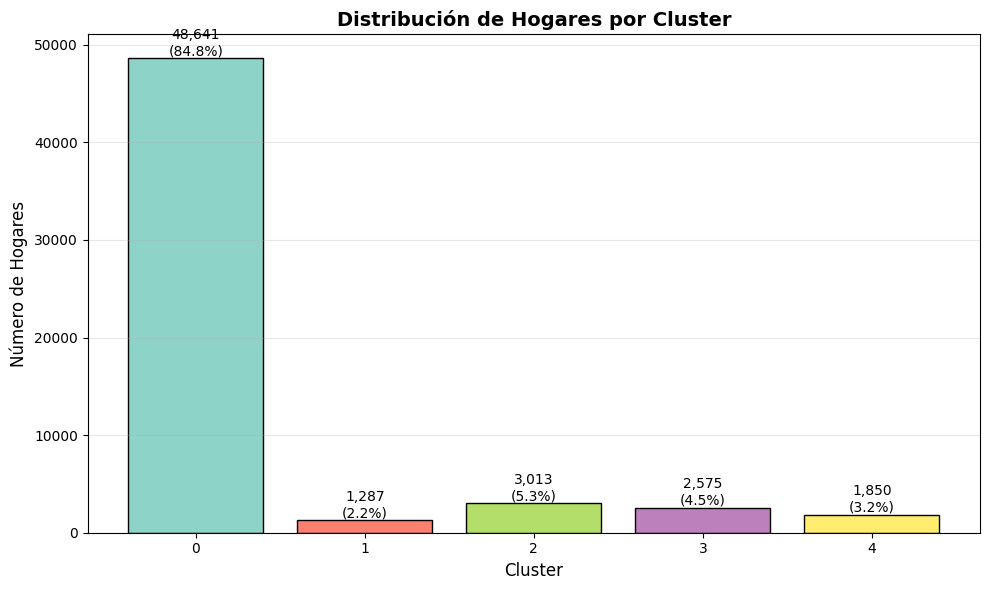

In [3]:
print("\n" + "="*80)
print("DISTRIBUCIÓN DE CLUSTERS")
print("="*80)

cluster_sizes = df_original['cluster'].value_counts().sort_index()

print(f"\nTamaño de cada cluster:\n")
for cluster_id in sorted(set(cluster_labels)):
    n_hogares = (cluster_labels == cluster_id).sum()
    pct = n_hogares / len(cluster_labels) * 100
    if cluster_id == -1:
        print(f"   Outliers:   {n_hogares:7,} hogares ({pct:5.2f}%)")
    else:
        print(f"   Cluster {cluster_id}: {n_hogares:7,} hogares ({pct:5.2f}%)")

# Visualizar distribución
fig, ax = plt.subplots(figsize=(10, 6))
clusters_plot = cluster_sizes[cluster_sizes.index >= 0]  # Sin outliers
colors = plt.cm.Set3(np.linspace(0, 1, len(clusters_plot)))

bars = ax.bar(clusters_plot.index.astype(str), clusters_plot.values, color=colors, edgecolor='black')
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Número de Hogares', fontsize=12)
ax.set_title('Distribución de Hogares por Cluster', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Añadir porcentajes
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:,.0f}\n({height/len(df_original)*100:.1f}%)',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('images/distribucion_clusters.png', dpi=150, bbox_inches='tight')
print(f"\nGráfico guardado: distribucion_clusters.png")
plt.show()

In [4]:

print("\n" + "="*80)
print("CALCULANDO EDAD")
print("="*80)

if 'r105a' in df_original.columns:
    print("\nCalculando edad desde año de nacimiento (r105a)...")
    
    # Año actual (2024 para el censo)
    ANIO_CENSO = 2024
    
    # Calcular edad
    df_original['edad'] = ANIO_CENSO - df_original['r105a']
    
    # Validar edades razonables (0-120 años)
    edades_invalidas = ((df_original['edad'] < 0) | (df_original['edad'] > 120)).sum()
    if edades_invalidas > 0:
        print(f"     {edades_invalidas:,} edades inválidas detectadas - corrigiendo...")
        df_original.loc[df_original['edad'] < 0, 'edad'] = np.nan
        df_original.loc[df_original['edad'] > 120, 'edad'] = np.nan
    
    print(f"  Edad calculada")
    print(f"  Rango de edades: {df_original['edad'].min():.0f} - {df_original['edad'].max():.0f} años")
    print(f"  Edad promedio: {df_original['edad'].mean():.1f} años")
else:
    print("\n Variable r105a no disponible - edad no se puede calcular")


CALCULANDO EDAD

Calculando edad desde año de nacimiento (r105a)...
  Edad calculada
  Rango de edades: 0 - 99 años
  Edad promedio: 35.0 años


In [5]:
print("\n" + "="*80)
print("DEFINICIÓN DE VARIABLES CLAVE")
print("="*80)

VARIABLES_INTERPRETACION = {
    'economicas': {
        'principales': [
            'ingpe',                    # Ingreso per cápita
            'ingfa',                    # Ingreso total del hogar
            'ingreso_independientes',   # Trabajo independiente
            'imeds',                    # Empleo dependiente
            'totayuda',                 # Remesas
            'pobreza',                  # Nivel de pobreza
            'imnl'                    # Ingresos no laborales (pensiones, rentas)
        ],
        'calculadas': [
            'dependencia_remesas',
            'gasto_total_estimado',
            'proporcion_gasto_ingreso'
        ]
    },
    'empleo': {
        'principales': [
            'actpr',        # Estado ocupacional
            'h411a',        # Horas trabajadas
            'd411b',        # Días trabajados semana pasada
            'd412b',        # Días habituales trabajados
            'segm',         # Segmentación laboral
            'ciuo414',      # Ocupación
            'ciiu416'       # Rama económica
        ],
        'calculadas': [
            'tiene_ocupado'
        ]
    },
    'demograficas': {
        'principales': [
            'edad',
            'r021a',                # Miembros del hogar (o r024, miemh_exdomestico)
            'r024',                 # Personas enfermas
            'miemh_exdomestico'
        ],
        'calculadas': [
            'menores_5',
            'razon_dependencia_simple',
            'proporcion_enfermos'
        ]
    },
    'educacion': {
        'principales': [
            'aproba1'  # Grados aprobados
        ]
    },
    'indices': {
        'calculadas': [
            'indice_bienestar',
            'indice_servicios',
            'indice_victimizacion',
            'indice_inseguridad'
        ]
    }
}

# Verificar qué variables están disponibles
variables_disponibles = {}
total_disponibles = 0
total_faltantes = 0

for categoria, subcategorias in VARIABLES_INTERPRETACION.items():
    variables_disponibles[categoria] = {}
    
    for subcategoria, vars_list in subcategorias.items():
        disponibles = [v for v in vars_list if v in df_original.columns]
        faltantes = [v for v in vars_list if v not in df_original.columns]
        
        variables_disponibles[categoria][subcategoria] = disponibles
        total_disponibles += len(disponibles)
        total_faltantes += len(faltantes)
        
        print(f"\n{categoria.upper()} - {subcategoria}:")
        print(f"   Disponibles: {len(disponibles)}/{len(vars_list)}")
        
        if faltantes:
            print(f"   Faltantes: {faltantes}")

print(f"\n📊 RESUMEN:")
print(f"   Total disponibles: {total_disponibles}")
print(f"   Total faltantes: {total_faltantes}")

# Crear lista plana de todas las variables disponibles
todas_vars = []
for categoria in variables_disponibles.values():
    for vars_list in categoria.values():
        todas_vars.extend(vars_list)

print(f"   Total variables para análisis: {len(todas_vars)}")


DEFINICIÓN DE VARIABLES CLAVE

ECONOMICAS - principales:
   Disponibles: 7/7

ECONOMICAS - calculadas:
   Disponibles: 3/3

EMPLEO - principales:
   Disponibles: 7/7

EMPLEO - calculadas:
   Disponibles: 1/1

DEMOGRAFICAS - principales:
   Disponibles: 3/4
   Faltantes: ['r021a']

DEMOGRAFICAS - calculadas:
   Disponibles: 3/3

EDUCACION - principales:
   Disponibles: 1/1

INDICES - calculadas:
   Disponibles: 4/4

📊 RESUMEN:
   Total disponibles: 29
   Total faltantes: 1
   Total variables para análisis: 29


In [6]:
print("\n" + "="*80)
print("PERFILES DETALLADOS POR CLUSTER")
print("="*80)

def crear_perfil_cluster_completo(df, cluster_id, variables_dict):
    """
    Crea perfil completo incluyendo imnl y edad
    """
    cluster_data = df[df['cluster'] == cluster_id]
    otros_data = df[df['cluster'] != cluster_id]
    
    perfil = {
        'Cluster': cluster_id,
        'N_Hogares': len(cluster_data),
        'Pct_Hogares': (len(cluster_data) / len(df)) * 100
    }
    
    # Variables económicas (incluyendo imnl)
    for var in variables_dict['economicas']['principales'] + variables_dict['economicas']['calculadas']:
        if var in df.columns:
            media_cluster = cluster_data[var].mean()
            media_otros = otros_data[var].mean()
            
            perfil[f'{var}_media'] = media_cluster
            perfil[f'{var}_vs_otros'] = ((media_cluster - media_otros) / abs(media_otros) * 100) if media_otros != 0 else 0
    
    # Variables empleo
    for var in variables_dict['empleo']['principales'] + variables_dict['empleo']['calculadas']:
        if var in df.columns:
            perfil[f'{var}_media'] = cluster_data[var].mean()
    
    # Variables demográficas (incluyendo edad)
    for var in variables_dict['demograficas']['principales'] + variables_dict['demograficas']['calculadas']:
        if var in df.columns:
            perfil[f'{var}_media'] = cluster_data[var].mean()
    
    # Educación
    for var in variables_dict['educacion']['principales']:
        if var in df.columns:
            perfil[f'{var}_media'] = cluster_data[var].mean()
    
    # Índices
    for var in variables_dict['indices']['calculadas']:
        if var in df.columns:
            perfil[f'{var}_media'] = cluster_data[var].mean()
    
    return perfil

# Crear perfiles
perfiles = []
for cluster_id in sorted(df_original['cluster'].unique()):
    if cluster_id == -1:
        continue
    perfil = crear_perfil_cluster_completo(df_original, cluster_id, VARIABLES_INTERPRETACION)
    perfiles.append(perfil)

df_perfiles = pd.DataFrame(perfiles)


PERFILES DETALLADOS POR CLUSTER


In [7]:
def asignar_nombre_con_imnl_edad(row):

    cluster_id = row['Cluster']
    pct = row['Pct_Hogares']
    
    # Indicadores clave
    ingpe = row.get('ingpe_media', 0)
    imnl = row.get('imnl_media', 0)
    educacion = row.get('aproba1_media', 0)
    horas_trabajo = row.get('h411a_media', 0)
    remesas = row.get('totayuda_media', 0)
    dep_remesas = row.get('dependencia_remesas_media', 0)
    edad = row.get('edad_media', 0)
    trabajo_indep = row.get('ingreso_independientes_media', 0)
    
    # 1. Cluster mayoritario (>80%)
    if pct > 80:
        if edad < 35:
            return "Jóvenes de Bajos Ingresos"
        else:
            return "Población General"
    
    # 2. Jubilados/Pensionados (edad alta + ingresos no laborales altos + pocas horas)
    if imnl > 200 and horas_trabajo < 15 and edad > 55:
        return "Jubilados y Pensionados"
    
    # 3. Dependientes de remesas (remesas altas, baja educación)
    if dep_remesas > 0.5 or remesas > 200:
        if edad > 50:
            return "Adultos Mayores Dependientes de Remesas"
        else:
            return "Familias con Migrantes"
    
    # 4. Elite emprendedora (trabajo independiente alto + horas altas)
    if trabajo_indep > 500 and horas_trabajo > 45:
        return "Clase Media-Alta Profesional"
    
    # 5. Trabajadores formales (horas altas, ingreso medio-bajo)
    if horas_trabajo > 40:
        if ingpe > 300:
            return "Clase Media Asalariada"
        else:
            return "Trabajadores Formales de Ingresos Medios"
    
    # 6. Clasificación por ingreso
    if ingpe > 350:
        if educacion > 9:
            return "Clase Media-Alta"
        else:
            return "Clase Media"
    elif ingpe > 200:
        return "Clase Media-Baja"
    else:
        if educacion < 6:
            return "Vulnerabilidad Alta"
        else:
            return "Trabajadores de Bajos Ingresos"

# Aplicar nombres
df_perfiles['Nombre'] = df_perfiles.apply(asignar_nombre_con_imnl_edad, axis=1)

print("\nPERFILES SOCIOECONÓMICOS COMPLETOS:\n")
print("="*80)

for idx, row in df_perfiles.iterrows():
    print(f"\nCLUSTER {row['Cluster']}: {row['Nombre']}")
    print(f"   {'─'*76}")
    print(f"   Población: {row['N_Hogares']:,} hogares ({row['Pct_Hogares']:.1f}%)")
    
    # DEMOGRAFÍA (ahora con edad)
    print(f"\n    DEMOGRAFÍA:")
    if 'edad_media' in row:
        print(f"      Edad promedio:             {row['edad_media']:.1f} años")
    if 'miemh_exdomestico_media' in row:
        print(f"      Miembros hogar:            {row['miemh_exdomestico_media']:.1f} personas")
    if 'menores_5_media' in row:
        print(f"      Menores de 5 años:         {row['menores_5_media']:.2f}")
    
    # ECONOMÍA (ahora con imnl destacado)
    print(f"\n    ECONOMÍA:")
    print(f"      Ingreso per cápita:        ${row.get('ingpe_media', 0):.2f}")
    
    if 'imnl_media' in row and row['imnl_media'] > 50:
        print(f"      Ingresos NO laborales:   ${row['imnl_media']:.2f}")
    
    if 'ingreso_independientes_media' in row and row['ingreso_independientes_media'] > 100:
        print(f"      Trabajo independiente:   ${row['ingreso_independientes_media']:.2f}")
    
    if 'totayuda_media' in row and row['totayuda_media'] > 100:
        print(f"      Remesas:                 ${row['totayuda_media']:.2f}")
    
    if 'ingfa_media' in row:
        print(f"      Ingreso familiar:          ${row['ingfa_media']:.2f}")
    if 'gasto_total_estimado_media' in row:
        print(f"      Gasto total:               ${row['gasto_total_estimado_media']:.2f}")
    if 'pobreza_media' in row:
        print(f"      Índice de pobreza:         {row['pobreza_media']:.2f}")
    
    # EMPLEO
    if 'h411a_media' in row:
        print(f"\n    EMPLEO:")
        print(f"      Horas trabajo/semana:      {row['h411a_media']:.1f} horas")
        if 'tiene_ocupado_media' in row:
            print(f"      % con empleo:              {row['tiene_ocupado_media']*100:.1f}%")
    
    # EDUCACIÓN
    if 'aproba1_media' in row:
        print(f"\n    EDUCACIÓN:")
        print(f"      Años educación:            {row['aproba1_media']:.1f} años")
    
    # ÍNDICES
    if 'indice_bienestar_media' in row:
        print(f"\n    ÍNDICES:")
        print(f"      Bienestar:                 {row['indice_bienestar_media']:.2f}")
        if 'indice_servicios_media' in row:
            print(f"      Servicios:                 {row['indice_servicios_media']:.2f}")

print("\n" + "="*80)


PERFILES SOCIOECONÓMICOS COMPLETOS:


CLUSTER 0: Jóvenes de Bajos Ingresos
   ────────────────────────────────────────────────────────────────────────────
   Población: 48,641 hogares (84.8%)

    DEMOGRAFÍA:
      Edad promedio:             31.6 años
      Miembros hogar:            4.1 personas
      Menores de 5 años:         0.31

    ECONOMÍA:
      Ingreso per cápita:        $197.32
      Ingreso familiar:          $753.96
      Gasto total:               $251.66
      Índice de pobreza:         2.56

    EMPLEO:
      Horas trabajo/semana:      16.3 horas
      % con empleo:              92.5%

    EDUCACIÓN:
      Años educación:            6.8 años

    ÍNDICES:
      Bienestar:                 0.07
      Servicios:                 1.70

CLUSTER 1: Clase Media-Alta Profesional
   ────────────────────────────────────────────────────────────────────────────
   Población: 1,287 hogares (2.2%)

    DEMOGRAFÍA:
      Edad promedio:             46.4 años
      Miembros hogar:      


TABLA COMPARATIVA DE PERFILES

COMPARACIÓN COMPLETA:



,Cluster,Nombre,N_Hogares,Pct_Hogares,Edad,Ingreso_PC,Ingr_NoLab,Remesas,Horas_Trab,Educación
0,0,Jóvenes de Bajos Ingresos,48641,84.79,31.60,197.32,4.62,43.02,16.30,6.76
1,1,Clase Media-Alta Profesional,1287,2.24,46.44,500.49,18.79,38.65,49.26,9.29
2,2,Trabajadores Formales de Ingresos Medios,3013,5.25,46.11,219.14,7.06,31.72,43.94,7.66
3,3,Adultos Mayores Dependientes de Remesas,2575,4.49,58.32,235.41,17.11,312.84,12.81,4.70
4,4,Jubilados y Pensionados,1850,3.22,65.30,373.78,391.83,37.05,6.22,8.84



HEATMAP DE CARACTERÍSTICAS

✅ Heatmap guardado: heatmap_completo_imnl_edad.png


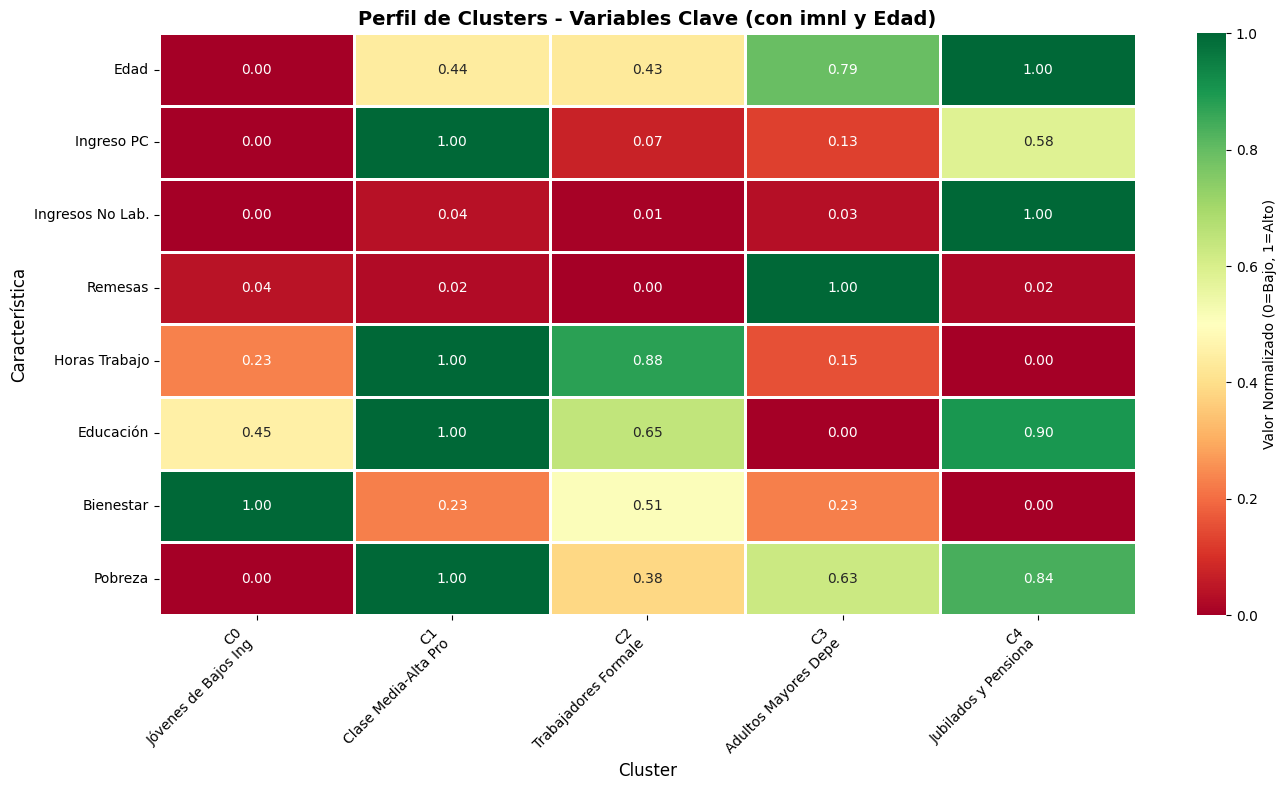

In [8]:
print("\n" + "="*80)
print("TABLA COMPARATIVA DE PERFILES")
print("="*80)

vars_tabla = ['Cluster', 'Nombre', 'N_Hogares', 'Pct_Hogares']

# Agregar variables clave
vars_importantes = [
    'edad_media',                   
    'ingpe_media',
    'imnl_media',                    
    'totayuda_media',
    'h411a_media',
    'aproba1_media'
]

vars_tabla.extend([v for v in vars_importantes if v in df_perfiles.columns])

df_tabla = df_perfiles[vars_tabla].copy()

# Renombrar
rename_dict = {
    'edad_media': 'Edad',
    'ingpe_media': 'Ingreso_PC',
    'imnl_media': 'Ingr_NoLab',      
    'totayuda_media': 'Remesas',
    'h411a_media': 'Horas_Trab',
    'aproba1_media': 'Educación'
}

df_tabla = df_tabla.rename(columns=rename_dict)

print("\nCOMPARACIÓN COMPLETA:\n")
display(df_tabla.round(2))


print("\n" + "="*80)
print("HEATMAP DE CARACTERÍSTICAS")
print("="*80)

# Variables para heatmap
vars_heatmap = [
    'edad_media',                  
    'ingpe_media',
    'imnl_media',                   
    'totayuda_media',
    'h411a_media',
    'aproba1_media',
    'indice_bienestar_media',
    'pobreza_media'
]

vars_heatmap_disponibles = [v for v in vars_heatmap if v in df_perfiles.columns]

if len(vars_heatmap_disponibles) >= 5:
    df_heatmap = df_perfiles[['Cluster'] + vars_heatmap_disponibles].set_index('Cluster')
    
    # Normalizar
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    df_heatmap_norm = pd.DataFrame(
        scaler.fit_transform(df_heatmap),
        index=df_heatmap.index,
        columns=df_heatmap.columns
    )
    
    # Renombrar para visualización
    columnas_limpias = {
        'edad_media': 'Edad',
        'ingpe_media': 'Ingreso PC',
        'imnl_media': 'Ingresos No Lab.', 
        'totayuda_media': 'Remesas',
        'h411a_media': 'Horas Trabajo',
        'aproba1_media': 'Educación',
        'indice_bienestar_media': 'Bienestar',
        'pobreza_media': 'Pobreza'
    }
    
    df_heatmap_norm = df_heatmap_norm.rename(columns=columnas_limpias)
    
    # Crear heatmap
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.heatmap(df_heatmap_norm.T, annot=True, fmt='.2f', cmap='RdYlGn', 
                cbar_kws={'label': 'Valor Normalizado (0=Bajo, 1=Alto)'},
                linewidths=1, ax=ax, vmin=0, vmax=1)
    
    # Nombres de clusters
    nombres_clusters = df_perfiles.set_index('Cluster')['Nombre'].to_dict()
    xticklabels = [f"C{int(idx)}\n{nombres_clusters[int(idx)][:20]}" 
                   for idx in df_heatmap_norm.index]
    ax.set_xticklabels(xticklabels, rotation=45, ha='right')
    
    ax.set_xlabel('Cluster', fontsize=12)
    ax.set_ylabel('Característica', fontsize=12)
    ax.set_title('Perfil de Clusters - Variables Clave (con imnl y Edad)', 
                 fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('images/heatmap_completo_imnl_edad.png', 
                dpi=150, bbox_inches='tight')
    print(f"\n✅ Heatmap guardado: heatmap_completo_imnl_edad.png")
    plt.show()


In [9]:
print("\n" + "="*80)
print("RECOMENDACIONES PARA POLÍTICAS PÚBLICAS")
print("="*80)

# Diccionario de recomendaciones actualizado
RECOMENDACIONES = {
    "Jovenes de Bajos Ingresos": """
ESTRATEGIA: Primera insercion laboral y formacion

PERFIL IDENTIFICADO:
   - Edad: ~32 anos (poblacion joven)
   - Educacion: 6.8 anos (primaria completa)
   - Problema: Subempleo (16h/semana)
   - Sin fuente de ingresos estable

1. EMPLEO Y CAPACITACION:
   - Programas de primer empleo para jovenes
   - Capacitacion tecnica en oficios demandados
   - Pasantias y aprendizajes remunerados
   - Subsidios al empleo para empresas que contraten jovenes
   - Intermediacion laboral especializada

2. EDUCACION:
   - Programas de educacion tecnica acelerada
   - Becas para terminar bachillerato
   - Educacion dual (estudio + trabajo)
   - Alfabetizacion digital

3. EMPRENDIMIENTO:
   - Microcreditos para jovenes emprendedores
   - Incubadoras de negocios
   - Capacitacion en gestion empresarial basica
   - Capital semilla para startups

4. PROTECCION SOCIAL:
   - Seguro de desempleo para primer empleo
   - Acceso a salud preventiva
   - Subsidios de transporte
    """,
    
    "Poblacion General": """
ESTRATEGIA: Mejora de calidad del empleo y formalizacion

PERFIL IDENTIFICADO:
   - Edad: Variable
   - Problema: Subempleo generalizado (16h/semana)
   - Ingreso: $197/mes (pobreza)
   - 85% de la poblacion

1. EMPLEO DE CALIDAD:
   - Programas de empleo temporal (40h/semana)
   - Incentivos a empresas por empleo formal
   - Fiscalizacion de derechos laborales
   - Salario minimo efectivo
   - Reduccion de informalidad

2. CAPACITACION MASIVA:
   - Centros de formacion tecnica en todo el pais
   - Capacitacion en demandas del mercado
   - Programas de recalificacion laboral
   - Certificacion de competencias

3. ECONOMIA FAMILIAR:
   - Subsidios focalizados por pobreza
   - Transferencias condicionadas
   - Apoyo alimentario
   - Subsidio de servicios basicos

4. ACCESO A SERVICIOS:
   - Salud gratuita o subsidiada
   - Educacion publica de calidad
   - Transporte publico accesible
   - Vivienda social
    """,
    
    "Clase Media-Alta Profesional": """
ESTRATEGIA: Retencion de talento e innovacion

PERFIL IDENTIFICADO:
   - Edad: ~46 anos (experiencia laboral plena)
   - Educacion: 9.3 anos (secundaria completa)
   - Trabajo independiente: $1,015/mes
   - Elite economica (2.2%)

1. AMBIENTE DE NEGOCIOS:
   - Reduccion de tramites burocraticos
   - Incentivos fiscales para PYMES
   - Acceso a creditos empresariales
   - Proteccion de propiedad intelectual
   - Facilitacion de exportaciones

2. INNOVACION:
   - Fondos para investigacion y desarrollo
   - Incubadoras y aceleradoras de negocios
   - Conectividad con mercados internacionales
   - Capacitacion en nuevas tecnologias

3. EDUCACION SUPERIOR:
   - Becas para posgrados nacionales e internacionales
   - Programas de actualizacion profesional
   - Formacion en gestion empresarial avanzada

4. RESPONSABILIDAD SOCIAL:
   - Incentivos fiscales por programas sociales
   - Alianzas publico-privadas
   - Mentoria a nuevos emprendedores
   - Inversion social corporativa
    """,
    
    "Trabajadores Formales de Ingresos Medios": """
ESTRATEGIA: Mejora salarial y movilidad social

PERFIL IDENTIFICADO:
   - Edad: ~46 anos
   - Trabajan tiempo completo (44h/semana)
   - Educacion: 7.7 anos
   - Problema: Bajos salarios a pesar de trabajar full-time

1. MEJORA SALARIAL:
   - Ajuste de salario minimo sectorial
   - Incentivos a productividad
   - Negociacion colectiva efectiva
   - Fiscalizacion de pagos justos

2. PROTECCION LABORAL:
   - Seguridad social obligatoria
   - Seguro de desempleo
   - Proteccion ante despidos injustificados
   - Derechos laborales garantizados

3. MOVILIDAD SOCIAL:
   - Capacitacion para ascensos
   - Educacion tecnica superior
   - Certificacion de competencias
   - Programas de carrera profesional

4. BIENESTAR:
   - Seguro medico familiar
   - Fondos de vivienda
   - Creditos educativos para hijos
   - Programas de ahorro para retiro
    """,
    
    "Adultos Mayores Dependientes de Remesas": """
ESTRATEGIA: Reduccion de dependencia y proteccion social

PERFIL IDENTIFICADO:
   - Edad: ~58 anos (pre-jubilacion)
   - Remesas: $312/mes (64% del ingreso)
   - Educacion: 4.7 anos (muy baja)
   - Trabajo local: 13h/semana (casi nulo)

1. DIVERSIFICACION DE INGRESOS:
   - Programas de empleo para adultos mayores
   - Microemprendimientos familiares
   - Uso productivo de remesas
   - Cooperativas comunitarias

2. EDUCACION Y CAPACITACION:
   - Alfabetizacion para adultos mayores
   - Capacitacion en oficios tradicionales
   - Educacion financiera
   - Gestion de remesas

3. PROTECCION SOCIAL:
   - Pension universal basica
   - Atencion geriatrica gratuita
   - Programas de salud preventiva
   - Subsidios para adultos mayores

4. DESARROLLO COMUNITARIO:
   - Proyectos productivos con remesas colectivas
   - Desarrollo de economias locales
   - Fortalecimiento de redes familiares
   - Clubes de adultos mayores

5. PREPARACION ANTE CRISIS:
   - Fondos de emergencia comunitarios
   - Seguros ante reduccion de remesas
   - Diversificacion economica familiar
    """,
    
    "Jubilados y Pensionados": """
ESTRATEGIA: Proteccion y dignidad en la tercera edad

PERFIL IDENTIFICADO:
   - Edad: ~65 anos (tercera edad)
   - Ingresos no laborales: $391/mes (pensiones/rentas)
   - Trabajo: 6h/semana (jubilados)
   - Clase media con patrimonio acumulado

1. PROTECCION DE PENSIONES:
   - Ajuste periodico de pensiones por inflacion
   - Proteccion legal de fondos de pensiones
   - Garantia de pago puntual
   - Pension minima garantizada

2. SALUD GERIATRICA:
   - Atencion medica especializada gratuita
   - Medicamentos subsidiados
   - Programas de prevencion de enfermedades cronicas
   - Atencion domiciliaria
   - Centros de dia para adultos mayores

3. CALIDAD DE VIDA:
   - Descuentos en servicios publicos
   - Transporte gratuito o subsidiado
   - Actividades recreativas y culturales
   - Programas de envejecimiento activo
   - Clubes sociales

4. PROTECCION PATRIMONIAL:
   - Asesoria legal gratuita
   - Proteccion contra abusos financieros
   - Gestion de patrimonio para herencias
   - Seguros de vida y gastos funerarios

5. PARTICIPACION SOCIAL:
   - Programas de voluntariado senior
   - Transferencia de conocimientos (mentoria)
   - Participacion en consejos consultivos
   - Reconocimiento social a trayectoria
    """,
    
    "Familias con Migrantes": """
ESTRATEGIA: Uso productivo de remesas y autonomia economica

PERFIL IDENTIFICADO:
   - Remesas altas pero menor dependencia que C3
   - Probablemente adultos en edad productiva
   - Potencial para invertir

1. INVERSION PRODUCTIVA:
   - Incentivos para invertir remesas en negocios
   - Creditos preferenciales complementarios a remesas
   - Asesoria para emprendimientos
   - Programas de cofinanciamiento

2. EDUCACION:
   - Becas para hijos de migrantes
   - Programas universitarios
   - Formacion tecnica superior
   - Intercambios educativos

3. DESARROLLO LOCAL:
   - Proyectos comunitarios con remesas colectivas
   - Infraestructura comunitaria
   - Empresas cooperativas
   - Desarrollo economico regional

4. VINCULACION CON MIGRANTES:
   - Programas de inversion desde el exterior
   - Facilidades para envio de remesas
   - Proteccion consular
   - Programas de retorno productivo
    """
}

# Mostrar recomendaciones
print("\nRECOMENDACIONES ESPECIFICAS POR PERFIL:\n")

for idx, row in df_perfiles.iterrows():
    nombre = row['Nombre']
    cluster_id = row['Cluster']
    n_hogares = row['N_Hogares']
    pct = row['Pct_Hogares']
    
    print("="*80)
    print(f"CLUSTER {cluster_id}: {nombre.upper()}")
    print("="*80)
    print(f"Poblacion: {n_hogares:,} hogares ({pct:.1f}%)")
    
    # Mostrar indicadores clave
    if 'edad_media' in row:
        print(f"Edad promedio: {row['edad_media']:.1f} anos")
    if 'ingpe_media' in row:
        print(f"Ingreso per capita: ${row['ingpe_media']:.2f}")
    if 'imnl_media' in row and row['imnl_media'] > 50:
        print(f"Ingresos no laborales: ${row['imnl_media']:.2f}")
    if 'totayuda_media' in row and row['totayuda_media'] > 50:
        print(f"Remesas: ${row['totayuda_media']:.2f}")
    
    print()
    
    # Buscar recomendacion
    recomendacion = None
    for key in RECOMENDACIONES.keys():
        if key.lower() in nombre.lower() or nombre.lower() in key.lower():
            recomendacion = RECOMENDACIONES[key]
            break
    
    # Mostrar recomendacion o generar una basica
    if recomendacion:
        print(recomendacion)
    else:
        print(f"""
ESTRATEGIA: Analisis detallado pendiente

Este perfil requiere un estudio mas profundo para determinar
las intervenciones mas adecuadas. Se recomienda:

1. Analisis cualitativo complementario
2. Grupos focales con hogares del cluster
3. Evaluacion de necesidades especificas
4. Coordinacion interinstitucional
        """)
    
    print("\n")


RECOMENDACIONES PARA POLÍTICAS PÚBLICAS

RECOMENDACIONES ESPECIFICAS POR PERFIL:

CLUSTER 0: JÓVENES DE BAJOS INGRESOS
Poblacion: 48,641 hogares (84.8%)
Edad promedio: 31.6 anos
Ingreso per capita: $197.32


ESTRATEGIA: Analisis detallado pendiente

Este perfil requiere un estudio mas profundo para determinar
las intervenciones mas adecuadas. Se recomienda:

1. Analisis cualitativo complementario
2. Grupos focales con hogares del cluster
3. Evaluacion de necesidades especificas
4. Coordinacion interinstitucional
        


CLUSTER 1: CLASE MEDIA-ALTA PROFESIONAL
Poblacion: 1,287 hogares (2.2%)
Edad promedio: 46.4 anos
Ingreso per capita: $500.49


ESTRATEGIA: Retencion de talento e innovacion

PERFIL IDENTIFICADO:
   - Edad: ~46 anos (experiencia laboral plena)
   - Educacion: 9.3 anos (secundaria completa)
   - Trabajo independiente: $1,015/mes
   - Elite economica (2.2%)

1. AMBIENTE DE NEGOCIOS:
   - Reduccion de tramites burocraticos
   - Incentivos fiscales para PYMES
   - Acceso

In [10]:
print("\n" + "="*80)
print("GUARDANDO RESULTADOS")
print("="*80)

df_perfiles.to_csv('output/perfiles_detallados.csv', index=False)
print(f"\nPerfiles guardados: perfiles_detallados.csv")

# Guardar dataset con nombres de clusters
df_tabla.to_csv('output/tabla_comparativa.csv', index=False)
print(f"Tabla comparativa guardada: tabla_comparativa.csv")

# Guardar dataset con nombres
df_original['nombre_cluster'] = df_original['cluster'].map(
    df_perfiles.set_index('Cluster')['Nombre'].to_dict()
)
df_original.to_parquet('output/dataset_final_con_nombres.parquet', 
                       compression='snappy', index=False)
print(f"Dataset final guardado: dataset_final_con_nombres.parquet")



GUARDANDO RESULTADOS

Perfiles guardados: perfiles_detallados.csv
Tabla comparativa guardada: tabla_comparativa.csv
Dataset final guardado: dataset_final_con_nombres.parquet
